In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
def draw_ellipse(position, covariance, ax=None, sigmaf=3, **kwargs):
    """
    Draw an ellipse with a given position and covariance
    """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance) # U = left singular vectors, s = singular values
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the ellipse
    ax.add_patch(Ellipse(position, sigmaf * width, sigmaf * height, angle=angle, **kwargs))

[Further read](https://users.cs.utah.edu/~tch/CS4640/resources/A%20geometric%20interpretation%20of%20the%20covariance%20matrix.pdf) on the background of that calculation $\uparrow$

## Gaussian Mixture Modelling Example
We will use `sklearn.mixture.GaussianMixture` to fit a GMM model to the data.

- [API docs](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
- [User guide](https://scikit-learn.org/stable/modules/mixture.html#gmm)
- [Implementation details](https://github.com/scikit-learn/scikit-learn/blob/093e0cf14/sklearn/mixture/_gaussian_mixture.py#L510)

Likelihood for point A: 0.0185
Likelihood for point B: 0.0014
Likelihood for point C: 0.0000
Likelihood for point D: 0.0903
Likelihood for point E: 0.1122
Likelihood for point F: 0.0137


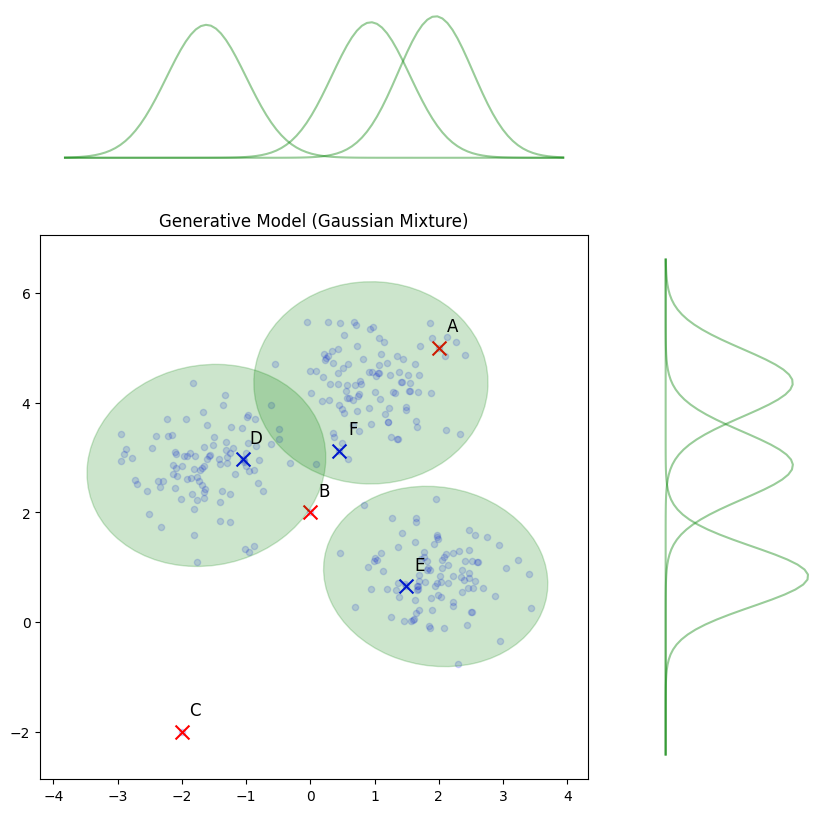

In [26]:
def plot_gmm(num_gaussians):
    np.random.seed(1)
    
    # Create synthetic data with three Gaussian clusters
    data, cluster_labels = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

    # Add some outliers
    outliers = np.array([[2, 5], [0, 2], [-2, -2]])
    data_with_outliers = np.vstack([outliers, data])
    

    clear_output(wait=True)
    display(widgets.HBox([slider, button]))


    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=num_gaussians, random_state=0)
    gmm.fit(data)


    # Calculate likelihoods for data points
    inliners = data[np.random.choice(data.shape[0], 3, replace=False)]
    samples = np.vstack([outliers, inliners])
    likelihoods = np.exp(gmm.score_samples(samples)) # gmm.score_samples gives log-likelihood


    # Print the likelihoods
    for i, likelihood in enumerate(likelihoods):
        print(f"Likelihood for point {chr(65+i)}: {likelihood:.4f}")

    # Plot the data and the outliers
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7))
    
    
    ax = fig.add_subplot(gs[1, 0])
    ax.set_title('Generative Model (Gaussian Mixture)')
    ax_x_dist = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_y_dist = fig.add_subplot(gs[1, 1], sharey=ax)
    
    ax.scatter(data_with_outliers[:, 0], data_with_outliers[:, 1], c='blue', alpha=0.15, s=20)
    ax.scatter(outliers[:, 0], outliers[:, 1], c='red', marker='x', s=100)  # highlighting outliers
    ax.scatter(inliners[:, 0], inliners[:, 1], c='blue', marker='x', s=100)  # highlighting inliniers
    for mean, cov in zip(gmm.means_, gmm.covariances_):
        draw_ellipse(mean, cov, ax=ax, alpha=0.2, color='green')


    # Label the outliers and the chosen inliers
    for i, coords in enumerate(samples):
        ax.annotate(chr(65+i), (coords[0]+0.3, coords[1]+0.3), fontsize=12, ha='right')
        
         
    # Marginal distributions for each Gaussian
    x_range = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    y_range = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    
    for i in range(num_gaussians):
        ax_x_dist.plot(x_range, norm.pdf(x_range, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i][0, 0])), color="green", alpha=0.4)
        ax_y_dist.plot(norm.pdf(y_range, gmm.means_[i, 1], np.sqrt(gmm.covariances_[i][1, 1])), y_range, color="green", alpha=0.4)

    # Hide axis labels for the marginals
    ax_x_dist.yaxis.set_ticklabels([])
    ax_y_dist.xaxis.set_ticklabels([])
    ax_x_dist.yaxis.set_ticks([])
    ax_y_dist.xaxis.set_ticks([])
    ax_x_dist.axis('off')
    ax_y_dist.axis('off')


    plt.show()

slider = widgets.IntSlider(value=3, min=1, max=20, description='Gaussians:', continuous_update=False)
button = widgets.Button(description="Plot GMM")

def on_button_clicked(_):
    plot_gmm(slider.value)

button.on_click(on_button_clicked)
display(widgets.HBox([slider, button]))

